# HIP application walkthrough - Matrix Multiplication

Often it is helpful to see a complete example that is fully explained in every detail. Matrix multiplication is a commonly employed compute operation and there are many math problems in STEM that can be reduced to simple matrix multiplication. We use it for a complete example with HIP. The  multiplication of matrices **A** and **B** proceeds by taking the dot product between every row **i0** in matrix **A** and every column **i1** of matrix **B**. If we multiply (elementwise) a row (at index **i0**) of matrix **A** with a column (at index **i1**) of Matrix B, then the dot product is the sum of the multiplied elements. The result of each dot product is then the value at position (i0,i1) in matrix **C**.

<figure style="margin-left:auto; margin-right:auto; width:80%;">
    <img style="vertical-align:middle" src="../images/matrix_multiplication.svg">
    <figcaption style= "text-align:lower; margin:1em; float:bottom; vertical-align:bottom;">Multiplying matrices A and B to get C. A dot product between row i0 of A and column i1 of B is computed to get the result in C at position (i0,i1).</figcaption>
</figure>


The strategy is to have a kernel compute the dot product for a single point (i0,i1) in Matrix C. This means every point in C is associated with a kernel, and the grid for this problem must be large enough to cover the **whole** of Matrix C. The source code for the example is in [mat_mult.cpp](mat_mult.cpp). Click on the link and open up the file in a different window.

## Import the environment

The command below brings the `run` and `build` commands within reach of the Jupyter notebook.

In [1]:
import os
os.environ['PATH'] = f"{os.environ['PATH']}:../install/bin"

# At a Bash terminal you need to do this instead
# source ../env

## The example program

Let's run the application and see the results, then we can understand how it works.

### Compile and run the program

The CMake build system is set to compile the example code [mat_mult.cpp](mat_mult.cpp). The program creates and fills matrices **A** and **B** with random numbers in the range [0-1] and then uses HIP to compute the solution in matrix **C**. The matrices are written to the following files in binary format:

* arrayA.dat
* arrayB.dat
* arrayC.dat

On your terminal change directory to **course_material/L3_Matrix_Multiplication** and compile and run with these commands, but without the exclamation mark!

In [2]:
!build mat_mult.exe; run mat_mult.exe

Consolidate compiler generated dependencies of target hip_helper
[ 50%] Built target hip_helper
Consolidate compiler generated dependencies of target mat_mult.exe
[100%] Built target mat_mult.exe
Install the project...
-- Install configuration: "RELEASE"
Device id: 0
	name:                                    Tesla T4
	global memory size:                      15652 MB
	available registers per block:           65536 
	max threads per SM or CU:                1024 
	maximum shared memory size per block:    49 KB
	maximum shared memory size per SM or CU: 0 KB
	maximum pitch size for memory copies:    2147 MB
	max block size:                          (1024,1024,64)
	max threads in a block:                  1024
	max Grid size:                           (2147483647,65535,65535)
Maximum error (infinity norm) is: 1.52588e-05


You should now be able to see the output files.

In [3]:
!ls *.dat

array_A.dat  array_B.dat  array_C.dat


### Loading the output matrices

A raw dump of the matrices in binary format is **not self-describing** nor is it **architecture independent**, however for teaching and debugging purposes it does provide a convenient way to quickly examine the output of the code and bridge the gap between Python and C++. We use the following code to read in the matrices, plot the output from the program, and compare it with a known solution from Numpy.

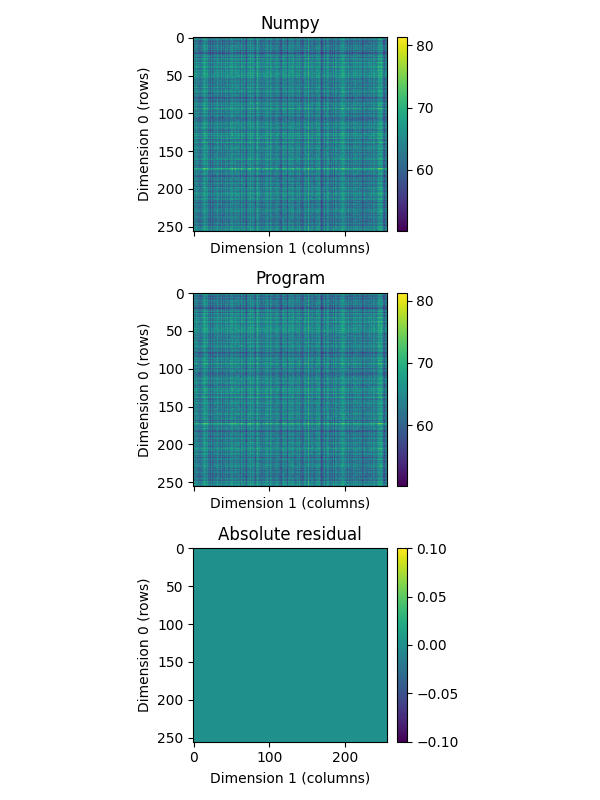

In [4]:
import os
import sys
import numpy as np
sys.path.insert(0, os.path.abspath("../common"))

import py_helper

%matplotlib widget

# Data type to use for matrices
dtype=np.float32

defines=py_helper.load_defines("mat_size.hpp")

# Load the size of the matrix from file
NCOLS_A = defines["NCOLS_A"]
NROWS_C = defines["NROWS_C"]
NCOLS_C = defines["NCOLS_C"]

# A is of size (NROWS_C, NCOLS_A)
# B is of size (NCOLS_A, NCOLS_C)    
# C is of size (NROWS_C, NCOLS_C)

mat_mul=py_helper.MatMul(NCOLS_A, NROWS_C, NCOLS_C, dtype)
mat_mul.load_data()
mat_mul.check_data()

## The example program - line by line

As covered in the Introduction, every accelerated application in HIP follows the same logical progression of steps: 

1. Compute resources discovered
1. Memory allocated on compute device/s
1. Memory copied from the host to the compute device/s
1. Kernels launched on the compute device/s
1. Host manages kernel synchronisation
1. Memory copied back from the compute device/s to the host
1. Steps 3 - 6 repeated as many times as necessary
1. Clean up resources and exit

For the matrix multiplication problem with HIP we use the following strategy:

1. **Parse program arguments**
1. Discover resources and choose a compute device
1. Construct matrices **A_h** and **B_h** on the host and fill them with random numbers
1. Allocate memory for arrays **A_d**, **B_d**, and **C_d** on the compute device
1. Upload matrices **A_h** and **B_h** from the host to **A_d** and **B_d** on the device
1. Run the kernel to compute **C_d** from **A_d** and **B_d** on the device
1. Copy the buffer for matrix **C_d** on the device back to **C_h** on the host
1. Test the computed matrix **C_h** against a known answer
1. Write the contents of matrices **A_h**, **B_h**, and **C_h** to disk
1. Clean up memory allocations and release resources

We now walk through every line of the source file [mat_mult.cpp](mat_mult.cpp) and explain how everything is working in as much depth as is practical. With HIP there is some boilerplate code and some best practices to be followed. In the following examples we have encapsulated both using helper functions. Each helper function starts with **h_** and is defined in the header file <a href="../common/hip_helper.hpp">hip_helper.hpp</a> and in the corresponding library <a href="../common/hip_helper.cpp">hip_helper.cpp</a>. It is helpful to have both the source code of the main program [mat_mult.cpp](mat_mult.cpp) and the helper sources <a href="../common/hip_helper.cpp">hip_helper.cpp</a> and <a href="../common/hip_helper.hpp">hip_helper.hpp</a> open while we traverse the code.

### Headers

We begin with some essential includes and include a file [mat_size.hpp](mat_size.hpp) that defines the size of the arrays being computed. 

```C++
// mat_mult.cpp

// Setup headers
#include <cassert>
#include <cmath>
#include <iostream>

// Bring in the size of the matrices
#include "mat_size.hpp"
```
Then we include the helper headers "hip_helper.hpp" to bring in a set of functions that reduce some of the tedious tasks of setting up resources.

```C++
// Bring in helper header to manage boilerplate code
#include "hip_helper.hpp"
```

In this instance the header <a href="../common/hip_helper.hpp">hip_helper.hpp</a> and the corresponding source file <a href="../common/hip_helper.cpp">hip_helper.cpp</a> are both located in the **course_material/common** directory.

### Step 1. Parse command line arguments

In a heterogeneous compute environment there may be more than one HIP device to choose from. We would like to be able to use command line arguments to select what devices are used. HIP just uses integers to select compute devices, and the  **h_parse_args** function parses command line arguments to fetch a device index from the command line.

```C++
// mat_mult.cpp source

// Parse command line arguments
int dev_index = h_parse_args(argc, argv);
```

The optional arguments we support are:

* \<id\>; a number for the index of the device
* **-h**, **--help**; print a help message and exit

By default we use device index 0.

#### Example usage with command line arguments

In [5]:
# Use the GPU at device index 0
!run mat_mult.exe 0

Device id: 0
	name:                                    Tesla T4
	global memory size:                      15652 MB
	available registers per block:           65536 
	max threads per SM or CU:                1024 
	maximum shared memory size per block:    49 KB
	maximum shared memory size per SM or CU: 0 KB
	maximum pitch size for memory copies:    2147 MB
	max block size:                          (1024,1024,64)
	max threads in a block:                  1024
	max Grid size:                           (2147483647,65535,65535)
Maximum error (infinity norm) is: 1.52588e-05


In [6]:
# Print some help information
!run mat_mult.exe -h

Usage: mat_mult.exe <options> <DEVICE_INDEX>
Options:
	-h,--help	 print help message
	DEVICE_INDEX is a number >= 0


Every example program in the course that makes use of **h_parse_args** will have these options.

### Sanity checking HIP function calls

Every call to a HIP function has some way of checking how it went, and it is **good practice** to always check the return value on these calls to ensure the function worked properly. The return type is a variable of type **hipError_t**, and there are a number of values that a variable of type **hipError_t** can store, a value of **hipSuccess** means that the function call was successful, and other values can mean something is wrong. The HIP function **hipGetErrorString** is useful for extracting the error string behind an error code and we use a helper function **h_errchk** to check error codes returned from HIP calls.

```C++
/// Function to check error codes
void h_errchk(hipError_t errcode, const char* message) {
    // Function to check the error code
    if (errcode != hipSuccess) { 
        const char* errstring = hipGetErrorString(errcode); 
        std::fprintf( 
            stderr, 
            "Error, HIP call failed at %s, error string is: %s\n", 
            message, 
            errstring 
        ); 
        exit(EXIT_FAILURE); 
    }
}
```

The following macro, defined as **H_ERRCHK** in <a href="../common/hip_helper.hpp">hip_helper.hpp</a> just calls **h_errchk** with the file and line number information as the message, as shown below:

```C++
/// Macro to check error codes.
#define H_ERRCHK(cmd) \
{\
    std::string file = __FILE__;\
    std::string mesg = file + ":" + std::to_string(__LINE__);\
    h_errchk(cmd, mesg.c_str());\
}
```

#### Example usage

The HIP function **hipInit** is used to explicitly initialise the HIP runtime. It returns a value of type **hipError_t**. We can use the **H_ERRCHK** macro to examine the output of **hipInit** in the following way:


```C++
// mat_mult.cpp source

H_ERRCHK(hipInit(0));
```

The macro will intercept the value from the output of the function and examine it to see if the function call returns **hipSuccess**. Otherwise it will crash the program with a useful error message.

### Step 2. Resource discovery

1. Parse program arguments
1. **Discover resources and choose a compute device**
1. Construct matrices **A_h** and **B_h** on the host and fill them with random numbers
1. Allocate memory for arrays **A_d**, **B_d**, and **C_d** on the compute device
1. Upload matrices **A_h** and **B_h** from the host to **A_d** and **B_d** on the device
1. Run the kernel to compute **C_d** from **A_d** and **B_d** on the device
1. Copy the buffer for matrix **C_d** on the device back to **C_h** on the host
1. Test the computed matrix **C_h** against a known answer
1. Write the contents of matrices **A_h**,**B_h**, and **C_h** to disk
1. Clean up memory alllocations and release resources

From the <a href="../L1_Introduction/Intro.ipynb">Introduction</a> we saw that device buffers are allocated on compute devices and their resources are managed by **contexts**. When handling multiple devices it **used to be good practice** to create at least one context for every device and for threads to "push" a context when needed, and "pop" the context afterwards. This created a lot of context management overhead and programmer headaches. 

<figure style="margin-left:auto; margin-right:auto; width:50%;">
    <img style="vertical-
                align:middle" src="../images/hip_components.svg">
    <figcaption style= "text-align:lower; margin:1em; float:bottom; vertical-align:bottom;">Picking  platforms, discovering devices, and creating contexts.</figcaption>
</figure>

Now the HIP API makes sure a primary context is available for a thread whenever a thread executes a HIP function. You can however explicitly initialise HIP with this call.

```C++
H_ERRCHK(hipInit(0));
```

Then you can choose which device to use with this call to **hipSetDevice**. Here we set device 0 as the one to use for subsequent operations.

```C++
H_ERRCHK(hipSetDevice(0))
```

When a number of compute devices are available, we can make sure they all are available and ready to go by cycling through the devices at the start of program runtime and making sure the primary contexts are initialised and clean. We use the helper function **h_acquire_devices** to initialise each compute device and context. 

```C++
    // mat_mult.cpp source, line 79
    h_acquire_devices(&num_devices, dev_index);
```

#### Examining **h_acquire_devices** in depth

We now examine the function **h_acquire_devices**, whose source code is in <a href="../common/hip_helper.cpp">hip_helper.cpp</a>. 

```C++
/// Function to simply acquire devices
void h_acquire_devices(int* num_devices, int default_device_id) {
    // Initialise HIP 
    h_errchk(hipInit(0));

    // Get the number of devices
    H_ERRCHK(hipGetDeviceCount(num_devices));

    // Check to make sure we have one or more suitable devices
    if (*num_devices <= 0) {
        std::printf("Failed to find a suitable compute device\n");
        exit(EXIT_FAILURE);
    }

    // Make sure the default device id is sane
    assert ((default_device_id<*num_devices) && (default_device_id>=0));

    // Clean and reset devices
    h_reset_devices(*num_devices);

    // Set the device
    h_errchk(hipSetDevice(default_device_id));
}
```

We use **hipInit** to initialise the HIP runtime, then we check the number of available devices with **hipGetDeviceCount** and make sure we have least one device. Then we call the helper function **h_reset_devices** to make sure all compute operations have finished, then make sure all contexts are clean. The reset operation deletes **all resources** managed by the primary contexts, and is **not strictly necessary** at program launch, but it might be useful to reset the state of the primary contexts if the function is called again at a later time.

```C++
/// Function to reset devices before and after runtime
void h_reset_devices(int num_devices) {
    
   // Reset devices
    for (int i = 0; i<num_devices; i++) {
        // Set device
        H_ERRCHK(hipSetDevice(i));

        // Synchronize device 
        H_ERRCHK(hipDeviceSynchronize());

        // Reset device (destroys primary context)
        H_ERRCHK(hipDeviceReset());

        // Set the device to reinitialise it
        H_ERRCHK(hipSetDevice(i));
    }
}
```

The function loops through the number of available compute devices and chooses the compute device to use with **hipSetDevice**. With this call a primary context is made available, if not already initialised, and that context is "selected" for future HIP calls on the host thread that called it. Any host thread may call **hipSetDevice** at any time to select the compute device to use. The function **hipDeviceSynchronize** ensures that everything using the context has finished, and **hipDeviceReset** then **releases all resources** that were previously managed by the primary context for the program on that device. A followup call to **hipSetDevice** then re-initialises the primary context. Now the primary context on each compute device has been refreshed and we can be certain that all contexts available to the program are in a clean state.

#### Compute device selection

Returning the the **h_acquire_devices** function, after the call to **h_reset_devices**, we use **hipSetDevice** to set the compute device to **default_device_id**.

```C++
    // hip_helper.cpp source 

    // Set the device
    h_errchk(hipSetDevice(default_device_id));
```

#### Fetch compute device capabilities

All compute devices have resource limits, such as the number of threads that can exist in a block, or the maximum size of a memory allocation. Sometimes it is necessary to explore these limits. Returning to the next line of text in [mat_mult.cpp](mat_mult.cpp) we call a helper function **h_report_on_device** to explore these limits and print a report on our chosen device at device index **dev_index**.

```C++
    // mat_mult.cpp source

    // Report on the device in use
    h_report_on_device(dev_index);
```

This will show us the following information:

* Name of the device
* Global memory size
* Available number of 32-bit registers
* Maximum shared memory size per block
* Maximum block size
* Maximum grid size

#### Examining **h_report_on_device** in depth

Below is the code for the function **h_report_on_device**. Given an integer device id, the function uses a call to **hipGetDeviceProperties** to fill a structure of type **hipDeviceProp_t** with the properties of the compute device. Then we use dot notation to access the elements of the structure and report back.

```C++
// hip_helper.cpp source

/// Function to report information on a compute device
void h_report_on_device(int device_id) {

    // Report some information on a compute device
    hipDeviceProp_t prop;

    // Get the properties of the compute device
    h_errchk(hipGetDeviceProperties(&prop, device_id));

    // ID of the compute device
    std::printf("Device id: %d\n", device_id);

    // Name of the compute device
    std::printf("\t%-40s %s\n","name:", prop.name);

    // Size of global memory
    std::printf("\t%-40s %lu MB\n","global memory size:", prop.totalGlobalMem/(1000000));

    // Maximum number of registers per block
    std::printf("\t%-40s %d \n","available registers per block:", prop.regsPerBlock);

    // Maximum shared memory size per block
    std::printf("\t%-40s %lu KB\n","maximum shared memory size per block:", prop.sharedMemPerBlock/(1000));

    // Maximum pitch size for memory copies (MB)
    std::printf("\t%-40s %lu MB\n","maximum pitch size for memory copies:", prop.memPitch/(1000000));

    // Print out the maximum number of threads along a dimension of a block
    std::printf("\t%-40s (", "max block size:");
    for (int n=0; n<2; n++) {
        std::printf("%d,", prop.maxThreadsDim[n]);
    }
    std::printf("%d)\n", prop.maxThreadsDim[2]); 
    std::printf("\t%-40s %d\n", "max threads in a block:", prop.maxThreadsPerBlock);
    
    // Print out the maximum size of a Grid
    std::printf("\t%-40s (", "max Grid size:");
    for (int n=0; n<2; n++) {
        std::printf("%d,", prop.maxGridSize[n]);
    }
    std::printf("%d)\n", prop.maxGridSize[2]); 
}

```

### Step 3. Construct matrices **A_h** and **B_h** on the host and fill them with random numbers

1. Parse program arguments
1. Discover resources and choose a compute device
1. **Construct matrices A_h and B_h on the host and fill them with random numbers**
1. Allocate memory for arrays **A_d**, **B_d**, and **C_d** on the compute device
1. Upload matrices **A_h** and **B_h** from the host to **A_d** and **B_d** on the device
1. Run the kernel to compute **C_d** from **A_d** and **B_d** on the device
1. Copy the buffer for matrix **C_d** on the device back to **C_h** on the host
1. Test the computed matrix **C_h** against a known answer
1. Write the contents of matrices **A_h**,**B_h**, and **C_h** to disk
1. Clean up memory alllocations and release resources

We need the matrices **A** and **B** filled with random numbers and available on the device. Of course we could have just allocated these arrays on the device and used a kernel to fill them with random numbers, however for teaching purposes we are going to create the arrays on the host, fill them with random numbers, then copy the arrays to the device.

```C++
    // mat_mult.cpp source

    size_t N1_A = NCOLS_A, N0_C = NROWS_C, N1_C = NCOLS_C;

    //// Step 3. Construct matrices A_h and B_h on the host 
    //// and fill them with random numbers ////
    
    // Number of bytes in each array
    size_t nbytes_A = N0_C*N1_A*sizeof(float);
    size_t nbytes_B = N1_A*N1_C*sizeof(float);
    size_t nbytes_C = N0_C*N1_C*sizeof(float);

    // Allocate memory for the host arrays
    float* A_h = (float*)h_alloc(nbytes_A);
    float* B_h = (float*)h_alloc(nbytes_B);
    float* C_h = (float*)h_alloc(nbytes_C);

    // Fill the host arrays with random numbers 
    // using the matrix helper library
    m_random(A_h, N0_C, N1_A);
    m_random(B_h, N1_A, N1_C);
```

Of course we could have used a call to **new**, **calloc**, or **malloc** to allocate memory for arrays **A_h**, **B_h**, and **C_h** on the host. For teaching purposes we use the helper function **h_alloc** to allocate `aligned memory` for the arrays instead. Aligned memory helps with enabling vector instructions on the CPU and optimising cache access. Here is the contents of **h_alloc** in <a href="../common/hip_helper.cpp">hip_helper.cpp</a>

```C++
/// Allocate aligned memory for use on the host
void* h_alloc(size_t nbytes) {
    // Get the alignment to use by default
    size_t alignment = h_get_alignment();
    
#if defined(_WIN32) || defined(_WIN64)
    void* buffer = _aligned_malloc(nbytes, alignment);
#else
    void* buffer = aligned_alloc(alignment, nbytes);
#endif
    // Zero out the contents of the allocation for safety
    memset(buffer, '\0', nbytes);
    return buffer;
}
```

Memory allocated with **h_alloc** must be freed with **free**, as shown at the end of the program.

```C++
    // Clean up host memory
    free(A_h);
    free(B_h);
    free(C_h);
```

> Notice that the memory allocations are labelled **A_h**, and **B_h**. The **_h** suffix in the name of the allocation is just *naming convention* to highlight that the memory is allocated on the host. 

Getting back to the program, we use the function **m_random** from our matrix helper library <a href="../include/mat_helper.hpp">mat_helper.hpp</a> in order to fill the allocations with random numbers in the range [0,1]. Feel free to look at the source code to see how this function works.

### Step 4. Allocate memory for arrays **A_d**, **B_d**, and **C_d** on the compute device

1. Parse program arguments
1. Discover resources and choose a compute device
1. Construct matrices **A_h** and **B_h** on the host and fill them with random numbers
1. **Allocate memory for arrays A_d, B_d, and C_d on the compute device**
1. Upload matrices **A_h** and **B_h** from the host to **A_d** and **B_d** on the device
1. Run the kernel to compute **C_d** from **A_d** and **B_d** on the device
1. Copy the buffer for matrix **C_d** on the device back to **C_h** on the host
1. Test the computed matrix **C_h** against a known answer
1. Write the contents of matrices **A_h**, **B_h**, and **C_h** to disk
1. Clean up memory alllocations and release resources

After choosing a compute device we now have a primary context through which we can manage allocations of memory on the compute device (buffers). The HIP function **hipMalloc** is used to allocate buffers on the compute device, as shown below:

```C++
    // mat_mult.cpp source

    //// Step 4. Allocate on-device memory for matrices A, B, and C ////
    float *A_d, *B_d, *C_d;
    H_ERRCHK(hipMalloc((void**)&A_d, nbytes_A));
    H_ERRCHK(hipMalloc((void**)&B_d, nbytes_B));
    H_ERRCHK(hipMalloc((void**)&C_d, nbytes_C));
```

> Note that we use the **_d** suffix (i.e **A_d**) for variable names to indicate that the memory allocation is on the device. This is just programming convention that might be helpful.

When we are done with this memory it is **best practice** to use the **hipFree** command to release the memory allocation on the compute device and free up resources. See these lines from the end of the program.

```C++
    // mat_mult.cpp source

    // Free the HIP buffers
    H_ERRCHK(hipFree(A_d));
    H_ERRCHK(hipFree(B_d));
    H_ERRCHK(hipFree(C_d));
```

### Step 5. Upload matrices **A_h** and **B_h** from the host to **A_d** and **B_d** on the device

The **hipMemcpy** function is a way to transfer memory between host and device. Here we use the function as follows:

```C++
    // mat_mult.cpp source

    // to the HIP device allocations ////
    H_ERRCHK(hipMemcpy(A_d, A_h, nbytes_A, hipMemcpyHostToDevice));
    H_ERRCHK(hipMemcpy(B_d, B_h, nbytes_B, hipMemcpyHostToDevice));
```

The first argument is always the destination pointer, and the second argument is the source. The last flag is to tell **hipMemcpy** what kind of copy to perform. Available flags are:

* hipMemcpyHostToHost
* hipMemcpyHostToDevice
* hipMemcpyDeviceToHost
* hipMemcpyDeviceToDevice
* hipMemcpyDefault

The last flag `hipMemcpyDefault` is to have the HIP runtime determine what kind of copy we are doing based on what memory the pointers are pointing to, however it is more readable to use the explicit flags.

### Step 6. Run the kernel to compute **C_d** from **A_d** and **B_d** on the device

1. Parse program arguments
1. Discover resources and choose a compute device
1. Construct matrices **A_h** and **B_h** on the host and fill them with random numbers
1. Allocate memory for arrays **A_d**, **B_d**, and **C_d** on the compute device
1. Upload matrices **A_h** and **B_h** from the host to **A_d** and **B_d** on the device
1. **Run the kernel to compute C_d from A_d and B_d on the device**
1. Copy the buffer for matrix **C_d** on the device back to **C_h** on the host
1. Test the computed matrix **C_h** against a known answer
1. Write the contents of matrices **A_h**, **B_h**, and **C_h** to disk
1. Clean up memory alllocations and release resources

During compilation of a program the HIP compiler separates out kernel code from host code. The host code is compiled to machine code and the kernel code is compiled either to an intermediate representation (or to a binary) for each selected (and/or available) GPU architecture. When a kernel is launched, either a binary is selected, or the intermediate representation code is JIT (Just In Time) compiled just before execution on the device. This strategy means two things:

* The kernel source can be part of the source file
* The first run of a kernel can be slower than subsequent runs due to compilation and caching overheads.

#### Kernel source code

In matrix multiplication a single value in matrix **C** at coordinates (i0, i1) is computed by taking the dot product between row **i0** of matrix **A** with column **i1** of matrix **B**. This means we walk along row **i0** of matrix **A**, and down column **i1** of matrix B, multiply elements together and add the product to a temporary sum. At the end of the walk the temporary sum is placed into matrix C at position **(i0,i1)**.

<figure style="margin-left:auto; margin-right:auto; width:80%;">
    <img style="vertical-align:middle" src="../images/matrix_multiplication.svg">
    <figcaption style= "text-align:lower; margin:1em; float:bottom; vertical-align:bottom;">Multiplying matrices A and B to get C.</figcaption>
</figure>

The function **mat_mult** in [mat_mult.cpp](mat_mult.cpp) is the kernel source, and it is in the same file as the program. We are free to choose how the kernel computes the matrix multiplication. In this instance **we choose to associate** a single kernel instance with every point **(i0, i1)** in matrix C. Here is the kernel source.

```C++
// standard matrix multiply kernel 
__global__ void mat_mult (
        float* A, 
        float* B, 
        float* C, 
        size_t N1_A, 
        size_t N0_C,
        size_t N1_C) { 
            
    // A is of size (N0_C, N1_A)
    // B is of size (N1_A, N1_C)
    // C is of size (N0_C, N1_C)   
    
    // i0 and i1 represent the coordinates in Matrix C 
    // We use row-major ordering for the matrices
    
    size_t i0 = blockIdx.y * blockDim.y + threadIdx.y;
    size_t i1 = blockIdx.x * blockDim.x + threadIdx.x;
    
    // Scratch variable
    float temp=0.0f; 

    // Guard mechanism to make sure we do not go
    // outside the boundaries of matrix C 
    if ((i0<N0_C) && (i1<N1_C)) {
        // Get the offset within the memory allocation of C
        size_t offset = i0*N1_C+i1;
        
        // Loop over columns of A and rows of B
        for (size_t n=0; n<N1_A; n++) {
            
            // A is of size (N0_C, N1_A)
            // B is of size (N1_A, N1_C)
            
            // Loop across row i0 of A
            // and down column i1 of B
            temp+=A[i0*N1_A+n]*B[i1+n*N1_C]; 
        }
        
        // Set the value in C at offset
        C[offset]=temp;
        
        // Uncomment this to perform elementwise matrix multiplication instead
        // C[offset]=A[offset]*B[offset];
    }
} 
```

#### The kernel line-by-line

Now we explain every line of the kernel.

##### Kernel preamble

The definition of our kernel is as follows:

```C++
__global__ void mat_mult (
        float* A, 
        float* B, 
        float* C, 
        size_t N1_A, 
        size_t N0_C,
        size_t N1_C) {
```
Qualifiers such as **\_\_global\_\_** help the compiler decide what to do with functions The qualifier **\_\_global\_\_** at the beginning signifies that the function is launched from the host and executed on the compute device, but cannot be run from within a kernel. Additional qualifiers that can be specified in the preamble are **\_\_device\_\_** which signifies that the function runs on the device and may be called by either a **kernel** or another device function. Finally the extra qualifier **\_\_host\_\_** means the function may also be called from the host. 

| Qualifier     | Purpose |
| ----------- | ----------- |
| \_\_global\_\_  | Specify that the function is a kernel to be launched from the host and run on the device |
| \_\_device\_\_ | Specify that a function is to be run on the device and called from a kernel or other device function |
| \_\_host\_\_ | Specify that a function is to be run on the host |

Qualifiers can be used in tandem, for example both **\_\_host\_\_** and **\_\_device\_\_** can be used together to specify a function that can run on both the host and the device, however **\_\_host\_\_** and **\_\_global\_\_** are mutually exclusive.

##### Kernel arguments

All kernels must have return type **void**. Arguments to the kernel are copied to the device **by value** when the kernel is called, and the number of arguments in the kernel must equal the number of arguments passed in when the kernel is launched. Memory allocations on the device are passed into the kernel via the pointer to that allocation. Within the kernel the allocation is accessed using array indexing (e.g C(i0,i1)). Memory may not be allocated dynamically within the kernel, therefore all memory allocations on the device must be performed beforehand from the host or at kernel launch (in the case of shared memory allocations).

##### Mapping coordinates from the grid to the matrix

We need a way to map the position within the grid to the coordinates **(i0, i1)** within matrix C. From the <a href="../L1_Introduction/L1 - Introduction.ipynb">Introduction</a> we know that a 3D grid (or execution space) is specified at kernel launch, and the runtime ensures that a kernel visits every part of that execution space. Kernels execute within blocks, and blocks make up the grid. 

<figure style="margin-left:auto; margin-right:auto; width:70%;">
    <img style="vertical-align:middle" src="../images/grid.svg">
    <figcaption style= "text-align:lower; margin:1em; float:bottom; vertical-align:bottom;">Three-dimensional Grid with Threads and blocks.</figcaption>
</figure>

Diagrams of the grid can be **awfully confusing**, but the important thing to keep to keep in mind is that with HIP **threads are neighbours along the x dimension of the Grid**. Within the kernel we have the following pre-defined structures that can help us determine where we are within the grid.

| Structure      | Purpose |
| ----------- | ----------- |
| gridDim.{xyz}  | How many blocks are along a dimension of the grid |
| blockDim.{xyz} | How many threads are along a dimension of a block |
| blockIdx.{xyz} | Index of the block along a dimension of the grid (0-based) |
| threadIdx.{xyz} | Index of the thread along a dimension of the block (0-based) |

For example we can find the position **p** of a thread/kernel along the x dimension of the grid using this diagram as an aid:

<figure style="margin-left:auto; margin-right:auto; width:80%;">
    <img style="vertical-align:middle" src="../images/grid_explained.svg">
    <figcaption style= "text-align:lower; margin:1em; float:bottom; vertical-align:bottom;">Finding our position p along the x dimension of the Grid using <b>blockIdx</b>, <b>blockDim</b>, and <b>threadIdx</b>. A similar calculation can be used to find the y, and z positions of the kernel within the grid.</figcaption>
</figure>

In the matrix multiplication kernel we are using row-major ordering for the matrices where dimension 1 is contiguous, so we choose that the `x` coordinate in the grid maps to coordinate `i1` in the matrices. Therefore in the kernel we use this mapping to get **(i0,i1)**.

```C++
    // mat_mult.cpp source

    // i0 and i1 represent the coordinates in Matrix C 
    // We assume row-major ordering for the matrices
    size_t i0 = blockIdx.y * blockDim.y + threadIdx.y;
    size_t i1 = blockIdx.x * blockDim.x + threadIdx.x;
```

Since we have chosen to associate a kernel invocation with every element of **C** we need a grid that is big enough to cover all the elements in matrix C. This means we must ensure that there are enough elements along dimension x of the grid to **cover dimension 1** of **matrix C**, and enough elements along dimension y of the grid to **cover dimension 0** of **matrix C**.

Now that we know the location of the thread (i0, i1) within matrix C we proceed to iterate along row **i0** of matrix **A**, and down column **i1** of matrix **B**. Since an integer number of blocks must fit within the grid, it is possible that the grid is larger than matrix **C**. Therefore we use a guard clause to make sure we don't run off the end of the arrays.
```C++
    // mat_mult.cpp source

    // Scratch variable
    float temp=0.0; 

    // Guard mechanism to make sure we do not go
    // outside the boundaries of matrix C 
    if ((i0<N0_C) && (i1<N1_C)) {
        // Loop over columns of A and rows of B
```        

##### Computing the dot product from within a kernel

Finally, we compute the dot product of row **i0** of **A** with column **i1** of **B** using a loop. Since we know N1_A is the number of **columns in A** and the number of **rows in B** we can use a loop over both. The starting offset in matrix **A** is **i0*N1_A** and the starting offset in matrix **B** is **i1**. During the loop we increment by a stride of 1 for matrix **A** and a stride of **N1_C** for matrix **B**. Once we finish the loop we can put the result back into **C** at an offset of **i0*N1_C + i1**.

<figure style="margin-left:auto; margin-right:auto; width:100%;">
    <img style="vertical-align:middle" src="../images/matrix_kernel_indexing.svg">
    <figcaption style= "text-align:lower; margin:1em; float:bottom; vertical-align:bottom;">Computation of the dot product. Shown are the starting offsets and strides for matrices A and B.</figcaption>
</figure>
        
```C++        
        // Get the offset within the memory allocation of C
        size_t offset = i0*N1_C+i1;
        
        // Loop over columns of A and rows of B
        for (size_t n=0; n<N1_A; n++) {
            
            // A is of size (N0_C, N1_A)
            // B is of size (N1_A, N1_C)
            
            // Loop across row i0 of A
            // and down column i1 of B
            temp+=A[i0*N1_A+n]*B[i1+n*N1_C]; 
        }
        
        // Set the value in C at offset
        C[offset]=temp;
        
        // Uncomment this to perform elementwise matrix multiplication instead
        // C[offset]=A[offset]*B[offset];
    }
} 
```

If you uncomment the last line of code, the kernel will perform elementwise matrix multiplication instead. Values in **A** at **offset** are multiplied with values in **B** at offset and the result is placed into **C** at offset.

#### Kernel launch

The next step in the process is to launch the kernel. The macro **hipLaunchKernelGGL** is the recommended way to launch HIP kernels. It needs as input the number of blocks along each dimension of the grid, the number of threads along each dimension of the block, as well as kernel arguments. Remember from the kernel source that we need to associate dimension `x` of the grid with dimension `1` of the matrix, and we need to associate dimension `y` of the grid with dimension `0` of the matrix. This must apply to the *block size* as well. Choosing the right block size is important for performance. Since kernels are executed in **teams of 64 wavefronts** it is best for performance if the number of threads in a block is a multiple of 64 but less than the maximum permissible number of threads in a block. The HIP structure type `dim3` stores the block size. We use a block size of (8,8,1) for this example because it is a multiple of 64, then we use a global size of {N1_C, N0_C} and the function **h_fit_blocks** to find the number of blocks in each dimension that adequately covers the global size. 

```C++
    // Desired block size
    dim3 block_size = { 8, 8, 1 };
    dim3 global_size = { (uint32_t)N1_C, (uint32_t)N0_C, 1 };
    dim3 grid_nblocks;
    
    // Choose the number of blocks so that Grid fits within it.
    h_fit_blocks(&grid_nblocks, global_size, block_size);
```

Now we can (finally!) run the kernel. The **hipLaunchKernelGGL** macro is a C/C++ compliant way to run kernels and is currently the recommended way to launch kernels in HIP.

```C++
    // Launch the kernel using hipLaunchKernelGGL method
    // Amount of shared memory to use in the kernel
    size_t sharedMemBytes=0;
    
    // Launch the kernel using hipLaunchKernelGGL method
    hipLaunchKernelGGL(mat_mult, 
            grid_nblocks, 
            block_size, sharedMemBytes, 0, 
            A_d, B_d, C_d,
            N1_A,
            N0_C,
            N1_C
    );
```

The first five parameters are part of the kernel launch: 

* **mat_mult**, the name of the kernel.
* **grid_nblocks**, the number of blocks along each dimension of the grid.
* **block_size**, the number of threads along each dimension of a block.
* **sharedMemBytes**, number of bytes to allocate for shared memory.
* **0**, the stream to use (0 specifies the null or default stream).

> Note: A stream is a queue where work (such as kernels and copies) is submitted. HIP has the ability to perform work concurrently using multiple streams. The default stream (stream 0) is the stream we use when we aren't trying to perform concurrent operations. Streams and concurrent operations are a topic for the more advanced modules.

The next 6 parameters (e.g. **A_d, B_d, C_d, N1_A, N0_C, N1_C**) are for the kernel itself. Memory allocations on the compute device are passed in via their pointer, and variables such as floats and integers may be passed in directly. When passing in variable you need to be **very careful** to match the data type of variables passed in with the data type that the kernel expects. I have encountered particularly nasty and hard to find bugs when the variable type passed in was different to what the kernel expected. Kernel launches are asynchronous in the sense that the **hipLaunchKernelGGL** macro returns immmediately. We also could have used the CUDA triple chevron (<<< >>>) syntax to launch kernels, however this is **not standard C++** syntax, nor is it as capable as the **hipLaunchKernelGGL** macro.

```C++
    mat_mult<<<grid_nblocks, block_size, sharedMemBytes, 0>>>(A_d, B_d, C_d, N1_A, N0_C, N1_C);
```

Either method of launching the kernel does not have a way of checking to see how the kernel went. Instead we can use the the function **hipGetLastError** to see how execution of the kernel went.

```C++
    // Check the status of the kernel launch
    H_ERRCHK(hipGetLastError());
```

Now the kernel is queued to the default stream, we explicitly wait for it to finish using the command:

```C++
    // Wait for any commands to complete on the compute device
    H_ERRCHK(hipDeviceSynchronize());
```



### Step 7. Copy the buffer for matrix **C_d** on the device back to **C_h** on the host

1. Parse program arguments
1. Discover resources and choose a compute device
1. Construct matrices **A_h** and **B_h** on the host and fill them with random numbers
1. Allocate memory for arrays **A_d**, **B_d**, and **C_d** on the compute device
1. Upload matrices **A_h** and **B_h** from the host to **A_d** and **B_d** on the device
1. Run the kernel to compute **C_d** from **A_d** and **B_d** on the device
1. **Copy the buffer for matrix C_d on the device back to C_h on the host**
1. Test the computed matrix **C_h** against a known answer
1. Write the contents of matrices **A_h**, **B_h**, and **C_h** to disk
1. Clean up memory alllocations and release resources

Once we have finished the kernel we now copy the memory from matrix C back to the host.

```C++
    //// Step 7. Copy the Buffer for matrix C back to the host ////
    H_ERRCHK(hipMemcpy(C_h, C_d, nbytes_C, hipMemcpyDeviceToHost));
```

Memory copies using **hipMemcpy** are synchronous, that means the call above will block until the copy is complete. Since the copy is using the same stream (the null stream) as the kernel above, then the copy will be queued right after the kernel function. This means that the copy would have waited for the kernel anyway, and the call to the **hipDeviceSynchronize** function was unnecessary. There is also a sister asynchronous copy function called **hipMemcpyAsync** which will only be asynchronous if the host memory is pinned (i.e allocated with **hipHostMalloc**) and only concurrent if another stream besides the null stream is used. We will discuss steams in a later lesson.

### Step 8. Test the computed matrix **C_h** against a known answer

In the matrix helper library <a href="../include/mat_helper.hpp">mat_helper.hpp</a> there is a function called **m_mat_mult** which performs the matrix multiplication inefficiently using just a single thread on the CPU. We allocate memory on the host for the solution **C_answer_h** and use **m_mat_mult** to compute **C_answer_h** using **A_h** and **B_h**. 

```C++
    // mat_mult.cpp source

    // Compute the serial solution using the matrix helper library
    float* C_answer_h = (float*)calloc(nbytes_C, 1);
    m_mat_mult(A_h, B_h, C_answer_h, N1_A, N0_C, N1_C);
    
    // Uncomment this to check against elementwise matrix multiplication
    // m_hadamard(A_h, B_h, C_answer_h, N0_C, N1_C);

    // Print the maximum error between matrices
    float max_err = m_max_error(C_h, C_answer_h, N0_C, N1_C);
```

The helper function **m_max_error** prints the maximum absolute difference between the two matrices (the infinity norm). This is the output you saw at the beginning. If you uncomment the **m_hadamard** line and recompile it checks the solution against Hadamard (elementwise) matrix multiplication. The error printed (as seen below) is the maximum absolute difference between the CPU solution and the HIP solution.

<code> Maximum error (infinity norm) is: 2.28882e-05</code>

### Step 9. Write the contents of matrices **A_h**, **B_h**, and **C_h** to disk

Now we use a helper function **h_write_binary** from <a href="../common/hip_helper.cpp">hip_helper.cpp</a> to write out the contents of arrays **A_h**, **B_h**, and **C_h** to disk.

```C++
    // Write out the host arrays to file
    h_write_binary(A_h, "array_A.dat", nbytes_A);
    h_write_binary(B_h, "array_B.dat", nbytes_B);
    h_write_binary(C_h, "array_C.dat", nbytes_C);
```

If we look at the source of **h_write_binary** we just use the standard library functions **fopen**, **fwrite**, and **fclose** to write a data allocation to disk. 

```C++
// hip_helper.cpp source

/// Write binary data to file
void h_write_binary(void* data, const char* filename, size_t nbytes) {
    // Write binary data to file
    std::FILE *fp = std::fopen(filename, "wb");
    if (fp == NULL) {
        std::printf("Error in writing file %s", filename);
        exit(OCL_EXIT);
    }
    
    // Write the data to file
    std::fwrite(data, nbytes, 1, fp);
    
    // Close the file
    std::fclose(fp);
}
```

### Step 10. Clean up memory alllocations and release resources

1. Parse program arguments
1. Discover resources and choose a compute device
1. Construct matrices **A_h** and **B_h** on the host and fill them with random numbers
1. Allocate memory for arrays **A_d**, **B_d**, and **C_d** on the compute device
1. Upload matrices **A_h** and **B_h** from the host to **A_d** and **B_d** on the device
1. Run the kernel to compute **C_d** from **A_d** and **B_d** on the device
1. Copy the buffer for matrix **C_d** on the device back to **C_h** on the host
1. Test the computed matrix **C_h** against a known answer
1. Write the contents of matrices **A_h**, **B_h**, and **C_h** to disk
1. **Clean up memory alllocations and release resources**

During resource cleanup it is good practice to **free all memory allocations on the host and the devices**, and then to reset the devices (refresh the primary contexts). Some profiling tools work best if the devices are reset at the end of the program. We use **hipFree** to free memory allocations on the compute device.

```C++
    // mat_mult.cpp source

    // Free the HIP buffers
    H_ERRCHK(hipFree(A_d));
    H_ERRCHK(hipFree(B_d));
    H_ERRCHK(hipFree(C_d));
```
Now we can free up the pinned host memory allocations using the function **hipHostFree**.

```C++
    // Clean up pinned memory on the host   
    H_ERRCHK(hipHostFree(A_h));
    H_ERRCHK(hipHostFree(B_h));
    H_ERRCHK(hipHostFree(C_h));
```
then we use just an ordinary **free** to free up the ordinary memory allocation for **C_answer_h**.

```C++
    // Free the answer matrix
    free(C_answer_h);
```

Finally, we use the helper function **h_reset_devices** to iterate through all compute devices and call the **hipDeviceReset** function to free all remaining compute resources and renew the primary contexts.
```C++
    // mat_mult.cpp

    // Reset compute devices
    h_reset_devices(num_devices);
```

## Summary

With this program we have used a farily straightforward math operation to explore in-depth, a majority of the machinery used in HIP applications. Of course there are libraries just as [hipBLAS](https://hipblas.readthedocs.io/) which implements matrix multiplcation for you, however this example provides a base to explore further topics such as profiling and optimisation, error checking and debugging, and managing streams with events.

<address>
Written by Dr. Toby Potter of <a href="https://www.pelagos-consulting.com">Pelagos Consulting and Education</a> for the <a href="https://pawsey.org.au">Pawsey Supercomputing Centre</a>.<br>
</address>